# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

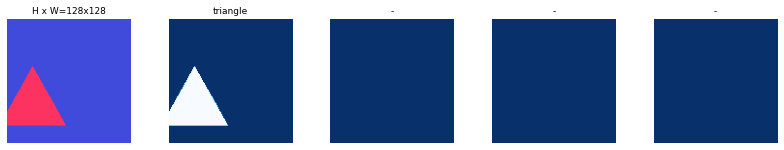

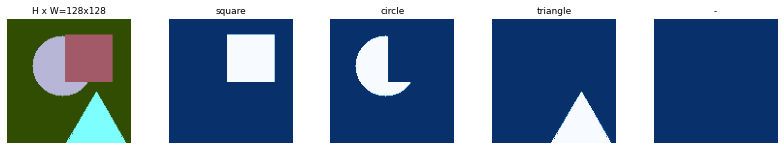

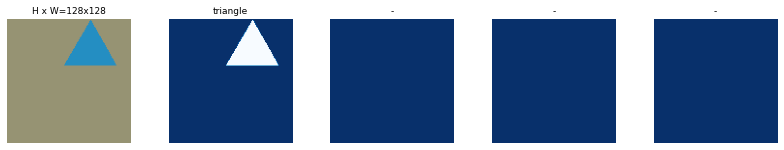

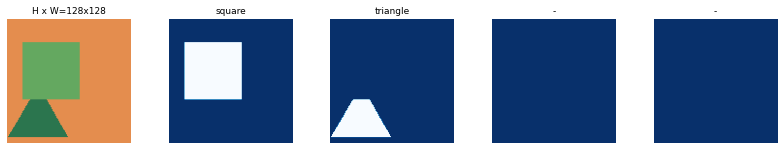

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\workspace\machine-learning\Mask_RCNN\logs\shapes20210430T1149\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrc

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/ROI/GatherV2_8_grad/Reshape_1:0", shape=(4092,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/ROI/GatherV2_8_grad/Reshape:0", shape=(4092, 4), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/ROI/GatherV2_8_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/ROI/GatherV2_9_grad/Reshape_1:0", shape=(4092,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/ROI/GatherV2_9_grad/Reshape:0", shape=(4092, 4), dtype=float32), d

  1/100 [..............................] - ETA: 48:22 - batch: 0.0000e+00 - size: 8.0000 - loss: 7.8149 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 3.0872 - mrcnn_class_loss: 2.8342 - mrcnn_bbox_loss: 1.1661 - mrcnn_mask_loss: 0.6203

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  2/100 [..............................] - ETA: 32:27 - batch: 0.5000 - size: 8.0000 - loss: 6.6015 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 2.1753 - mrcnn_class_loss: 2.3631 - mrcnn_bbox_loss: 1.2601 - mrcnn_mask_loss: 0.7121    

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  3/100 [..............................] - ETA: 33:01 - batch: 1.0000 - size: 8.0000 - loss: 5.7060 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.7909 - mrcnn_class_loss: 1.9546 - mrcnn_bbox_loss: 1.2070 - mrcnn_mask_loss: 0.6681

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  4/100 [>.............................] - ETA: 33:25 - batch: 1.5000 - size: 8.0000 - loss: 5.4096 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 1.7649 - mrcnn_class_loss: 1.7683 - mrcnn_bbox_loss: 1.1601 - mrcnn_mask_loss: 0.6349

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  5/100 [>.............................] - ETA: 32:24 - batch: 2.0000 - size: 8.0000 - loss: 5.0626 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.6073 - mrcnn_class_loss: 1.6399 - mrcnn_bbox_loss: 1.1091 - mrcnn_mask_loss: 0.6293

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  6/100 [>.............................] - ETA: 31:46 - batch: 2.5000 - size: 8.0000 - loss: 4.7638 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.4937 - mrcnn_class_loss: 1.5017 - mrcnn_bbox_loss: 1.0738 - mrcnn_mask_loss: 0.6198

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  7/100 [=>............................] - ETA: 30:42 - batch: 3.0000 - size: 8.0000 - loss: 4.5292 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.4059 - mrcnn_class_loss: 1.3952 - mrcnn_bbox_loss: 1.0482 - mrcnn_mask_loss: 0.6079

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  8/100 [=>............................] - ETA: 29:50 - batch: 3.5000 - size: 8.0000 - loss: 4.3574 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.3703 - mrcnn_class_loss: 1.3104 - mrcnn_bbox_loss: 1.0140 - mrcnn_mask_loss: 0.5947

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

  9/100 [=>............................] - ETA: 29:03 - batch: 4.0000 - size: 8.0000 - loss: 4.1505 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.2782 - mrcnn_class_loss: 1.2328 - mrcnn_bbox_loss: 0.9897 - mrcnn_mask_loss: 0.5831

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 10/100 [==>...........................] - ETA: 28:24 - batch: 4.5000 - size: 8.0000 - loss: 3.9962 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.2426 - mrcnn_class_loss: 1.1628 - mrcnn_bbox_loss: 0.9553 - mrcnn_mask_loss: 0.5708

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 11/100 [==>...........................] - ETA: 27:58 - batch: 5.0000 - size: 8.0000 - loss: 3.8401 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.1848 - mrcnn_class_loss: 1.1021 - mrcnn_bbox_loss: 0.9318 - mrcnn_mask_loss: 0.5600

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 12/100 [==>...........................] - ETA: 27:30 - batch: 5.5000 - size: 8.0000 - loss: 3.6936 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.1571 - mrcnn_class_loss: 1.0298 - mrcnn_bbox_loss: 0.9074 - mrcnn_mask_loss: 0.5409

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 13/100 [==>...........................] - ETA: 27:00 - batch: 6.0000 - size: 8.0000 - loss: 3.5872 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.9887 - mrcnn_bbox_loss: 0.8806 - mrcnn_mask_loss: 0.5311

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 14/100 [===>..........................] - ETA: 26:33 - batch: 6.5000 - size: 8.0000 - loss: 3.4978 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.0956 - mrcnn_class_loss: 0.9546 - mrcnn_bbox_loss: 0.8642 - mrcnn_mask_loss: 0.5288

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 15/100 [===>..........................] - ETA: 26:03 - batch: 7.0000 - size: 8.0000 - loss: 3.3768 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.0516 - mrcnn_class_loss: 0.9132 - mrcnn_bbox_loss: 0.8442 - mrcnn_mask_loss: 0.5155

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 16/100 [===>..........................] - ETA: 25:34 - batch: 7.5000 - size: 8.0000 - loss: 3.3030 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.0237 - mrcnn_class_loss: 0.8870 - mrcnn_bbox_loss: 0.8294 - mrcnn_mask_loss: 0.5124

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 17/100 [====>.........................] - ETA: 25:06 - batch: 8.0000 - size: 8.0000 - loss: 3.2680 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.0523 - mrcnn_class_loss: 0.8543 - mrcnn_bbox_loss: 0.8084 - mrcnn_mask_loss: 0.5036

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 18/100 [====>.........................] - ETA: 24:41 - batch: 8.5000 - size: 8.0000 - loss: 3.1766 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.0203 - mrcnn_class_loss: 0.8246 - mrcnn_bbox_loss: 0.7920 - mrcnn_mask_loss: 0.4917

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 19/100 [====>.........................] - ETA: 24:16 - batch: 9.0000 - size: 8.0000 - loss: 3.0887 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9895 - mrcnn_class_loss: 0.7954 - mrcnn_bbox_loss: 0.7747 - mrcnn_mask_loss: 0.4830

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 20/100 [=====>........................] - ETA: 23:51 - batch: 9.5000 - size: 8.0000 - loss: 3.0088 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.9601 - mrcnn_class_loss: 0.7695 - mrcnn_bbox_loss: 0.7607 - mrcnn_mask_loss: 0.4740

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 21/100 [=====>........................] - ETA: 23:28 - batch: 10.0000 - size: 8.0000 - loss: 2.9518 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.9439 - mrcnn_class_loss: 0.7535 - mrcnn_bbox_loss: 0.7449 - mrcnn_mask_loss: 0.4661

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 22/100 [=====>........................] - ETA: 23:07 - batch: 10.5000 - size: 8.0000 - loss: 2.8765 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.9175 - mrcnn_class_loss: 0.7319 - mrcnn_bbox_loss: 0.7296 - mrcnn_mask_loss: 0.4554

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 23/100 [=====>........................] - ETA: 22:47 - batch: 11.0000 - size: 8.0000 - loss: 2.8199 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8976 - mrcnn_class_loss: 0.7160 - mrcnn_bbox_loss: 0.7154 - mrcnn_mask_loss: 0.4494

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 24/100 [======>.......................] - ETA: 22:41 - batch: 11.5000 - size: 8.0000 - loss: 2.7676 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.8840 - mrcnn_class_loss: 0.7007 - mrcnn_bbox_loss: 0.6992 - mrcnn_mask_loss: 0.4432

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 25/100 [======>.......................] - ETA: 22:38 - batch: 12.0000 - size: 8.0000 - loss: 2.7114 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.8643 - mrcnn_class_loss: 0.6847 - mrcnn_bbox_loss: 0.6876 - mrcnn_mask_loss: 0.4351

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 26/100 [======>.......................] - ETA: 22:29 - batch: 12.5000 - size: 8.0000 - loss: 2.6498 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.8482 - mrcnn_class_loss: 0.6642 - mrcnn_bbox_loss: 0.6735 - mrcnn_mask_loss: 0.4252

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 27/100 [=======>......................] - ETA: 22:19 - batch: 13.0000 - size: 8.0000 - loss: 2.5957 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.8347 - mrcnn_class_loss: 0.6460 - mrcnn_bbox_loss: 0.6609 - mrcnn_mask_loss: 0.4161

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 28/100 [=======>......................] - ETA: 22:06 - batch: 13.5000 - size: 8.0000 - loss: 2.5583 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.8268 - mrcnn_class_loss: 0.6337 - mrcnn_bbox_loss: 0.6517 - mrcnn_mask_loss: 0.4085

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 29/100 [=======>......................] - ETA: 21:52 - batch: 14.0000 - size: 8.0000 - loss: 2.5068 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8098 - mrcnn_class_loss: 0.6198 - mrcnn_bbox_loss: 0.6397 - mrcnn_mask_loss: 0.4007

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 30/100 [========>.....................] - ETA: 21:39 - batch: 14.5000 - size: 8.0000 - loss: 2.4705 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.7975 - mrcnn_class_loss: 0.6106 - mrcnn_bbox_loss: 0.6325 - mrcnn_mask_loss: 0.3938

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 31/100 [========>.....................] - ETA: 21:24 - batch: 15.0000 - size: 8.0000 - loss: 2.4337 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7859 - mrcnn_class_loss: 0.5989 - mrcnn_bbox_loss: 0.6268 - mrcnn_mask_loss: 0.3865

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 32/100 [========>.....................] - ETA: 21:11 - batch: 15.5000 - size: 8.0000 - loss: 2.4033 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.7778 - mrcnn_class_loss: 0.5887 - mrcnn_bbox_loss: 0.6201 - mrcnn_mask_loss: 0.3812

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 33/100 [========>.....................] - ETA: 20:57 - batch: 16.0000 - size: 8.0000 - loss: 2.3697 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.7696 - mrcnn_class_loss: 0.5763 - mrcnn_bbox_loss: 0.6112 - mrcnn_mask_loss: 0.3776

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 34/100 [=========>....................] - ETA: 20:40 - batch: 16.5000 - size: 8.0000 - loss: 2.3358 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.5684 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.3727

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 35/100 [=========>....................] - ETA: 20:25 - batch: 17.0000 - size: 8.0000 - loss: 2.2975 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.7479 - mrcnn_class_loss: 0.5562 - mrcnn_bbox_loss: 0.5935 - mrcnn_mask_loss: 0.3661

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 36/100 [=========>....................] - ETA: 20:10 - batch: 17.5000 - size: 8.0000 - loss: 2.2692 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 0.5484 - mrcnn_bbox_loss: 0.5860 - mrcnn_mask_loss: 0.3598

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 37/100 [==========>...................] - ETA: 19:52 - batch: 18.0000 - size: 8.0000 - loss: 2.2499 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.7420 - mrcnn_class_loss: 0.5403 - mrcnn_bbox_loss: 0.5795 - mrcnn_mask_loss: 0.3550

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 38/100 [==========>...................] - ETA: 19:34 - batch: 18.5000 - size: 8.0000 - loss: 2.2208 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.5314 - mrcnn_bbox_loss: 0.5722 - mrcnn_mask_loss: 0.3504

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 39/100 [==========>...................] - ETA: 19:18 - batch: 19.0000 - size: 8.0000 - loss: 2.1951 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7267 - mrcnn_class_loss: 0.5241 - mrcnn_bbox_loss: 0.5657 - mrcnn_mask_loss: 0.3461

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 40/100 [===========>..................] - ETA: 19:02 - batch: 19.5000 - size: 8.0000 - loss: 2.1715 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.7192 - mrcnn_class_loss: 0.5160 - mrcnn_bbox_loss: 0.5600 - mrcnn_mask_loss: 0.3441

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 41/100 [===========>..................] - ETA: 18:44 - batch: 20.0000 - size: 8.0000 - loss: 2.1481 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.7153 - mrcnn_class_loss: 0.5077 - mrcnn_bbox_loss: 0.5535 - mrcnn_mask_loss: 0.3397

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 42/100 [===========>..................] - ETA: 18:27 - batch: 20.5000 - size: 8.0000 - loss: 2.1166 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.7078 - mrcnn_class_loss: 0.4978 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.3338

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 43/100 [===========>..................] - ETA: 18:08 - batch: 21.0000 - size: 8.0000 - loss: 2.0895 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.4894 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.3284

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 44/100 [============>.................] - ETA: 17:51 - batch: 21.5000 - size: 8.0000 - loss: 2.0692 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.6987 - mrcnn_class_loss: 0.4830 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.3239

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 45/100 [============>.................] - ETA: 17:34 - batch: 22.0000 - size: 8.0000 - loss: 2.0481 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.6945 - mrcnn_class_loss: 0.4770 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.3186

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 46/100 [============>.................] - ETA: 17:15 - batch: 22.5000 - size: 8.0000 - loss: 2.0275 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.6875 - mrcnn_class_loss: 0.4711 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.3162

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 47/100 [=============>................] - ETA: 16:53 - batch: 23.0000 - size: 8.0000 - loss: 2.0036 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.6827 - mrcnn_class_loss: 0.4636 - mrcnn_bbox_loss: 0.5148 - mrcnn_mask_loss: 0.3121

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 48/100 [=============>................] - ETA: 16:33 - batch: 23.5000 - size: 8.0000 - loss: 1.9828 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.6758 - mrcnn_class_loss: 0.4577 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.3094

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 49/100 [=============>................] - ETA: 16:15 - batch: 24.0000 - size: 8.0000 - loss: 1.9629 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.6733 - mrcnn_class_loss: 0.4506 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.3051

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 50/100 [==============>...............] - ETA: 15:57 - batch: 24.5000 - size: 8.0000 - loss: 1.9378 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6673 - mrcnn_class_loss: 0.4425 - mrcnn_bbox_loss: 0.4979 - mrcnn_mask_loss: 0.3006

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 51/100 [==============>...............] - ETA: 15:39 - batch: 25.0000 - size: 8.0000 - loss: 1.9205 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.6651 - mrcnn_class_loss: 0.4360 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.2973

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 52/100 [==============>...............] - ETA: 15:21 - batch: 25.5000 - size: 8.0000 - loss: 1.9010 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.6612 - mrcnn_class_loss: 0.4297 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.2937

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 53/100 [==============>...............] - ETA: 15:03 - batch: 26.0000 - size: 8.0000 - loss: 1.8855 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.6577 - mrcnn_class_loss: 0.4244 - mrcnn_bbox_loss: 0.4836 - mrcnn_mask_loss: 0.2906

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 54/100 [===============>..............] - ETA: 14:44 - batch: 26.5000 - size: 8.0000 - loss: 1.8713 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.6543 - mrcnn_class_loss: 0.4187 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.2889

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 55/100 [===============>..............] - ETA: 14:26 - batch: 27.0000 - size: 8.0000 - loss: 1.8559 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.6527 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.2855

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 56/100 [===============>..............] - ETA: 14:07 - batch: 27.5000 - size: 8.0000 - loss: 1.8420 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6515 - mrcnn_class_loss: 0.4082 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.2829

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 57/100 [================>.............] - ETA: 13:49 - batch: 28.0000 - size: 8.0000 - loss: 1.8246 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.6474 - mrcnn_class_loss: 0.4024 - mrcnn_bbox_loss: 0.4658 - mrcnn_mask_loss: 0.2804

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 58/100 [================>.............] - ETA: 13:31 - batch: 28.5000 - size: 8.0000 - loss: 1.8091 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.2786

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 59/100 [================>.............] - ETA: 13:13 - batch: 29.0000 - size: 8.0000 - loss: 1.7953 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.6393 - mrcnn_class_loss: 0.3925 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.2763

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 60/100 [=================>............] - ETA: 12:55 - batch: 29.5000 - size: 8.0000 - loss: 1.7809 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.6361 - mrcnn_class_loss: 0.3871 - mrcnn_bbox_loss: 0.4552 - mrcnn_mask_loss: 0.2744

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 61/100 [=================>............] - ETA: 12:37 - batch: 30.0000 - size: 8.0000 - loss: 1.7682 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.6316 - mrcnn_class_loss: 0.3830 - mrcnn_bbox_loss: 0.4524 - mrcnn_mask_loss: 0.2732

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 62/100 [=================>............] - ETA: 12:20 - batch: 30.5000 - size: 8.0000 - loss: 1.7542 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.6285 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.2717

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 63/100 [=================>............] - ETA: 12:00 - batch: 31.0000 - size: 8.0000 - loss: 1.7404 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6263 - mrcnn_class_loss: 0.3730 - mrcnn_bbox_loss: 0.4436 - mrcnn_mask_loss: 0.2697

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 64/100 [==================>...........] - ETA: 11:43 - batch: 31.5000 - size: 8.0000 - loss: 1.7280 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.2685

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 65/100 [==================>...........] - ETA: 11:27 - batch: 32.0000 - size: 8.0000 - loss: 1.7148 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6192 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.4360 - mrcnn_mask_loss: 0.2670

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 66/100 [==================>...........] - ETA: 11:10 - batch: 32.5000 - size: 8.0000 - loss: 1.7004 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.3604 - mrcnn_bbox_loss: 0.4319 - mrcnn_mask_loss: 0.2644

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 67/100 [===================>..........] - ETA: 10:53 - batch: 33.0000 - size: 8.0000 - loss: 1.6880 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6134 - mrcnn_class_loss: 0.3567 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.2621

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 68/100 [===================>..........] - ETA: 10:36 - batch: 33.5000 - size: 8.0000 - loss: 1.6755 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6124 - mrcnn_class_loss: 0.3522 - mrcnn_bbox_loss: 0.4242 - mrcnn_mask_loss: 0.2594

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 69/100 [===================>..........] - ETA: 10:18 - batch: 34.0000 - size: 8.0000 - loss: 1.6622 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6090 - mrcnn_class_loss: 0.3481 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.2574

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 70/100 [====================>.........] - ETA: 9:59 - batch: 34.5000 - size: 8.0000 - loss: 1.6500 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6073 - mrcnn_class_loss: 0.3437 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.2552 

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 71/100 [====================>.........] - ETA: 9:39 - batch: 35.0000 - size: 8.0000 - loss: 1.6401 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.2535

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 72/100 [====================>.........] - ETA: 9:20 - batch: 35.5000 - size: 8.0000 - loss: 1.6298 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6020 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.2523

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 73/100 [====================>.........] - ETA: 9:00 - batch: 36.0000 - size: 8.0000 - loss: 1.6199 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.3343 - mrcnn_bbox_loss: 0.4078 - mrcnn_mask_loss: 0.2507

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 74/100 [=====================>........] - ETA: 8:39 - batch: 36.5000 - size: 8.0000 - loss: 1.6083 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.3311 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.2490

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 75/100 [=====================>........] - ETA: 8:19 - batch: 37.0000 - size: 8.0000 - loss: 1.5980 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.5949 - mrcnn_class_loss: 0.3279 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.2476

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 76/100 [=====================>........] - ETA: 7:58 - batch: 37.5000 - size: 8.0000 - loss: 1.5920 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.5938 - mrcnn_class_loss: 0.3257 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.2469

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 77/100 [======================>.......] - ETA: 7:38 - batch: 38.0000 - size: 8.0000 - loss: 1.5848 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.5918 - mrcnn_class_loss: 0.3232 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.2461

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 78/100 [======================>.......] - ETA: 7:18 - batch: 38.5000 - size: 8.0000 - loss: 1.5753 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5893 - mrcnn_class_loss: 0.3198 - mrcnn_bbox_loss: 0.3951 - mrcnn_mask_loss: 0.2451

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 79/100 [======================>.......] - ETA: 7:00 - batch: 39.0000 - size: 8.0000 - loss: 1.5648 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.2432

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 80/100 [=======================>......] - ETA: 6:42 - batch: 39.5000 - size: 8.0000 - loss: 1.5556 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5854 - mrcnn_class_loss: 0.3134 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.2415

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 81/100 [=======================>......] - ETA: 6:23 - batch: 40.0000 - size: 8.0000 - loss: 1.5469 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5824 - mrcnn_class_loss: 0.3111 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.2405

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 82/100 [=======================>......] - ETA: 6:05 - batch: 40.5000 - size: 8.0000 - loss: 1.5393 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.2399

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 83/100 [=======================>......] - ETA: 5:46 - batch: 41.0000 - size: 8.0000 - loss: 1.5302 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.5786 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.2382

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 84/100 [========================>.....] - ETA: 5:28 - batch: 41.5000 - size: 8.0000 - loss: 1.5219 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.2364

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 85/100 [========================>.....] - ETA: 5:08 - batch: 42.0000 - size: 8.0000 - loss: 1.5149 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5754 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.2348

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 86/100 [========================>.....] - ETA: 4:48 - batch: 42.5000 - size: 8.0000 - loss: 1.5082 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.3756 - mrcnn_mask_loss: 0.2342

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 87/100 [=========================>....] - ETA: 4:28 - batch: 43.0000 - size: 8.0000 - loss: 1.5006 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.5732 - mrcnn_class_loss: 0.2968 - mrcnn_bbox_loss: 0.3728 - mrcnn_mask_loss: 0.2327

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 88/100 [=========================>....] - ETA: 4:09 - batch: 43.5000 - size: 8.0000 - loss: 1.4932 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.5724 - mrcnn_class_loss: 0.2943 - mrcnn_bbox_loss: 0.3703 - mrcnn_mask_loss: 0.2312

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 89/100 [=========================>....] - ETA: 3:50 - batch: 44.0000 - size: 8.0000 - loss: 1.4876 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 0.2925 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.2298

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 90/100 [==========================>...] - ETA: 3:30 - batch: 44.5000 - size: 8.0000 - loss: 1.4812 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.2905 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.2286

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 91/100 [==========================>...] - ETA: 3:10 - batch: 45.0000 - size: 8.0000 - loss: 1.4734 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.2269

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 92/100 [==========================>...] - ETA: 2:50 - batch: 45.5000 - size: 8.0000 - loss: 1.4676 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.3623 - mrcnn_mask_loss: 0.2261

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 93/100 [==========================>...] - ETA: 2:29 - batch: 46.0000 - size: 8.0000 - loss: 1.4618 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5669 - mrcnn_class_loss: 0.2843 - mrcnn_bbox_loss: 0.3607 - mrcnn_mask_loss: 0.2253

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 94/100 [===========================>..] - ETA: 2:08 - batch: 46.5000 - size: 8.0000 - loss: 1.4552 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.3588 - mrcnn_mask_loss: 0.2243

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 95/100 [===========================>..] - ETA: 1:47 - batch: 47.0000 - size: 8.0000 - loss: 1.4462 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5630 - mrcnn_class_loss: 0.2800 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.2226

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 96/100 [===========================>..] - ETA: 1:26 - batch: 47.5000 - size: 8.0000 - loss: 1.4408 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5621 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.2219

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 97/100 [============================>.] - ETA: 1:05 - batch: 48.0000 - size: 8.0000 - loss: 1.4334 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5603 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.3527 - mrcnn_mask_loss: 0.2205

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 98/100 [============================>.] - ETA: 43s - batch: 48.5000 - size: 8.0000 - loss: 1.4268 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.3507 - mrcnn_mask_loss: 0.2194 

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

 99/100 [============================>.] - ETA: 21s - batch: 49.0000 - size: 8.0000 - loss: 1.4200 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5577 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.3484 - mrcnn_mask_loss: 0.2179

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 1.4146 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5574 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.2167 

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\workspace\machine-learning\mask_rcnn\env\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

100/100 [==============================] - 2228s 22s/step - batch: 49.5000 - size: 8.0000 - loss: 1.4146 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5574 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.2167 - val_loss: 0.8122 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.4908 - val_mrcnn_class_loss: 0.0761 - val_mrcnn_bbox_loss: 0.1465 - val_mrcnn_mask_loss: 0.0854


SyntaxError: invalid syntax (<ipython-input-15-8251b0dcb215>, line 1)

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


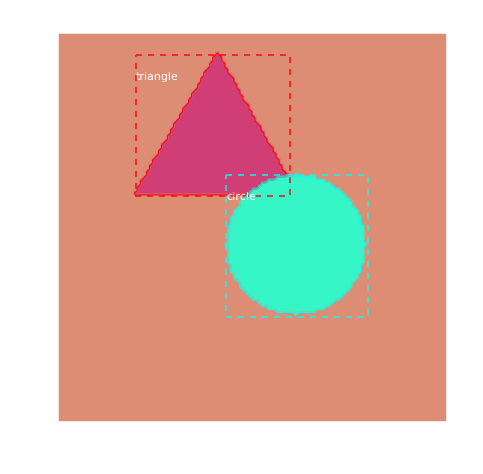

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


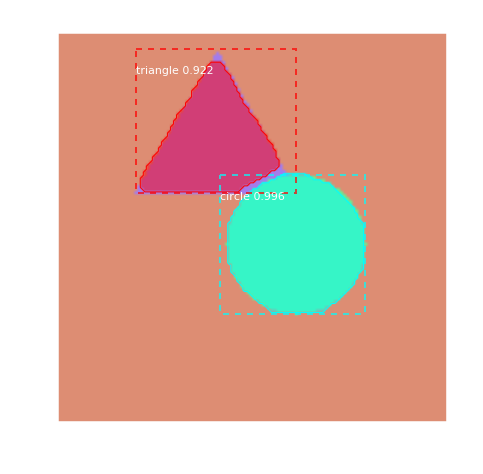

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
